## Link to Information on Dataset

http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html

### Read Environment

In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error


### Load movie titles + genres

In [2]:
movies = pd.read_csv('data/movies.csv')

In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


### Load movie ratings

In [4]:
ratings =pd.read_csv('data/ratings.csv')

In [5]:
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Merge titles with ratings

In [6]:
df= ratings.merge(movies,on='movieId', how='left')
df.head()


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


#### drop unneeded timestamp column

In [7]:
df = df.drop(columns='timestamp')

In [8]:
df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


# Exploration on genres

In [9]:

# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 4361],
 ['Comedy', 3756],
 ['Thriller', 1894],
 ['Action', 1828],
 ['Romance', 1596]]

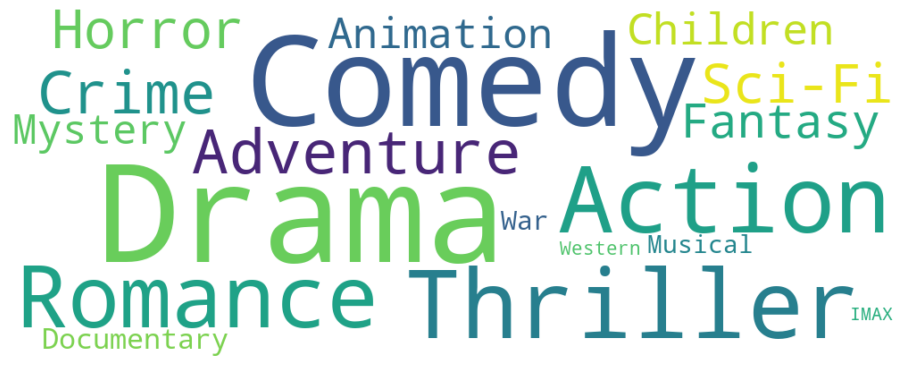

In [10]:

genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


# Exploration on ratings

In [11]:
rate = df['rating'].value_counts().sort_index(ascending=False)

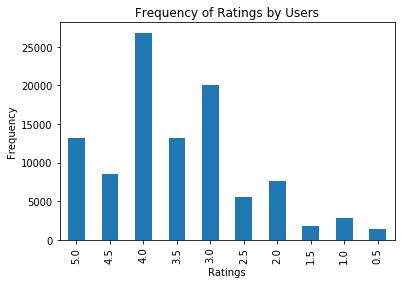

In [12]:
fig, ax = plt.subplots()
ax = rate.plot(kind="bar")
ax.set_ylabel('Frequency')
ax.set_xlabel('Ratings')
ax.set_title('Frequency of Ratings by Users')
plt.savefig('images/ratings.png')
plt.show()


# Making recommendations with Surprise

In [13]:
ratings_df = ratings.drop(columns='timestamp') 

In [14]:
from surprise import Reader, Dataset
reader = Reader()
data = Dataset.load_from_df(ratings_df, reader)
# loooks like load from df is looking for hte uid, iid, and r values as the columns
# Need to make sure they are in the right order!!!

In [15]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


In [16]:
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)

In [17]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8684964669610116, 'mae': 0.6679040427323815}
{'rmse': {'n_factors': 100, 'reg_all': 0.05}, 'mae': {'n_factors': 20, 'reg_all': 0.02}}


In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(weights='distance')


In [19]:
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.973715  , 0.97127618, 0.97221846, 0.97521647, 0.96938268]))
('test_mae', array([0.75244464, 0.74976037, 0.75288778, 0.75354958, 0.74549344]))
('fit_time', (0.6484508514404297, 0.707176923751831, 0.6649701595306396, 0.6623430252075195, 0.6927921772003174))
('test_time', (2.350398063659668, 2.2945058345794678, 2.2677669525146484, 2.3539910316467285, 2.365379810333252))
-----------------------
0.9723617586065314


In [20]:
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [21]:
for i in cv_knn_baseline.items():
    print(i)

np.mean(cv_knn_baseline['test_rmse'])

('test_rmse', array([0.87342361, 0.87416134, 0.87597258, 0.87359325, 0.88526172]))
('test_mae', array([0.66860115, 0.66493275, 0.66786702, 0.67046048, 0.67313009]))
('fit_time', (1.0313589572906494, 1.0598530769348145, 0.9923431873321533, 0.9655020236968994, 0.9174637794494629))
('test_time', (3.6366679668426514, 3.42653226852417, 3.4105751514434814, 3.1652169227600098, 2.954457998275757))


0.8764825004263777

In [22]:
svd = SVD(n_factors=50, reg_all=0.05)

In [23]:
svd.fit(dataset)

In [24]:
svd.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=2.9477319809214477, details={'was_impossible': False})

### Making recommendations for a new user

#### The new user's theoretical early preferences

In [25]:
user_rating = [{'userId': 1000, 'movieId': 55245, 'rating': '5'},
 {'userId': 1000, 'movieId': 2491, 'rating': '4'},
 {'userId': 1000, 'movieId': 4718, 'rating': '4'},
 {'userId': 1000, 'movieId': 4718, 'rating': '5'},
 {'userId': 1000, 'movieId': 5990, 'rating': '3'}]

In [26]:
new_ratings_df = ratings_df.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [27]:
svd_ = SVD(n_factors= 100, reg_all=0.05)
svd_.fit(new_data.build_full_trainset())

In [28]:
list_of_movies = []
for m_id in ratings_df['movieId'].unique():
    list_of_movies.append( (m_id,svd_.predict(1000,m_id)[3]))

In [29]:
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)


In [30]:
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies,5)

Recommendation #  1 :  277    Shawshank Redemption, The (1994)
Name: title, dtype: object 

Recommendation #  2 :  2623    Outlaw Josey Wales, The (1976)
Name: title, dtype: object 

Recommendation #  3 :  585    Wallace & Gromit: The Best of Aardman Animatio...
Name: title, dtype: object 

Recommendation #  4 :  1284    Good Will Hunting (1997)
Name: title, dtype: object 

Recommendation #  5 :  2462    Boondock Saints, The (2000)
Name: title, dtype: object 



# Making Our Own Recommendations System

In [31]:
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [32]:
movie_df = movies.drop(columns = 'genres')

In [33]:
#merge ratings with movie titles
df = pd.merge(ratings_df, movie_df, on='movieId')

In [34]:
df.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [35]:
movie_ratingCount = df.groupby(by= ['title'])['rating'].count().reset_index().rename(columns = {'rating': 'totalRatingCount'})[['title', 'totalRatingCount']]


In [36]:
movie_ratingCount.head()

,title,totalRatingCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


In [37]:
rating_with_totalRatingCount = df.merge(movie_ratingCount,
                                        left_on = 'title', right_on = 'title', how='left')

In [38]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(movie_ratingCount.describe())

       totalRatingCount
count          9719.000
mean             10.375
std              22.406
min               1.000
25%               1.000
50%               3.000
75%               9.000
max             329.000


### Trim dataset to only movies with 50 ratings (for expediency's sake)

In [39]:
# popularity_threshhold = 50
# rating_popular_movie = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshhold')


In [40]:
# rating_popular_movie.shape

### Find each user's average rating in order to normalize them

In [41]:
average_ratings = df.groupby(by= ['userId'])['rating'].mean().reset_index().rename(columns = {'rating': 'avg_rating'})[['userId', 'avg_rating']]

In [42]:
average_ratings.head()

,userId,avg_rating
0,1,4.366
1,2,3.948
2,3,2.436
3,4,3.556
4,5,3.636


### Create a pivot table or users, movies, and ratings

In [43]:
movie_features_df = rating_with_totalRatingCount.pivot_table(index = 'userId', columns='title', values = 'rating')

In [44]:
movie_features_df

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,4.000,nan
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
607,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
608,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,4.500,3.500,nan,nan,nan


### Add each user's average rating to the pivot table

In [45]:
rating_with_totalRatingCount_and_avg = movie_features_df.merge(average_ratings,
                                        left_on = 'userId', right_on = 'userId', how='left')

In [46]:
rating_with_totalRatingCount_and_avg

,userId,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),avg_rating
0,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,4.000,nan,4.366
1,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.948
2,3,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.436
3,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.556
4,5,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.657
606,607,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.786
607,608,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,4.500,3.500,nan,nan,nan,3.134
608,609,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.270


### Set index to user ID

In [47]:
rating_with_totalRatingCount_and_avg.set_index('userId', inplace=True)

In [48]:
rating_with_totalRatingCount_and_avg

,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),avg_rating
userId,,,,,,,,,,,,,,,,,,,,,
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,4.000,nan,4.366
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.948
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.436
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.556
5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.657
607,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.786
608,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,4.500,3.500,nan,nan,nan,3.134


#### Subtract average rating from all ratings

In [49]:
scaled_rating_with_totalRatingCount_and_avg = rating_with_totalRatingCount_and_avg.apply(lambda rating : rating - rating_with_totalRatingCount_and_avg.avg_rating)

#### drop average rating column (no longer needed)

In [50]:
scaled_rating_with_totalRatingCount_and_avg.drop(columns='avg_rating', inplace=True)

#### Fill nan values with 0 (now their average rating)

In [51]:
scaled_rating_with_totalRatingCount_and_avg.fillna(0, inplace=True)

#### Shorten df name

In [52]:
new_features_df = scaled_rating_with_totalRatingCount_and_avg

In [53]:
new_features_df

,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.366,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
607,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
608,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,1.366,0.366,0.000,0.000,0.000


### Create Sparse Matrix

In [54]:
new_features_df_matrix = csr_matrix(new_features_df.values)

### Make and fit KNN model

In [55]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(new_features_df_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [56]:
# I don't think we need this anymore because it's enacted in the get_new_movies function
# distance, indices = model_knn.kneighbors(new_features_df.iloc[5].values.reshape(1,-1), n_neighbors = 6)

#### compare neighbors' movies with user movies and return difference

In [57]:
def compare_neighbor_movies(userId, neighbor):
    different_movies = []
    for movie, rating in new_features_df.loc[userId].items():
        if rating == 0:
            for movie2, rating2 in new_features_df.iloc[neighbor].items():
                if movie == movie2 and rating2 > 0:
                    different_movies.append(movie)
    return different_movies


#### Find neighbors and get new movies

In [58]:
def get_new_movies(userId, knn_model):
    new_movies = []
    k = 6
    while len(list(set(new_movies))) < 10:
        distance, indices = knn_model.kneighbors(new_features_df.loc[userId].values.reshape(1,-1), n_neighbors = k)
        for neighbor in indices[0][1::]:
            new_movies += compare_neighbor_movies(userId, neighbor)
        k += 1
    return list(set(new_movies))

In [59]:
def score_movie(userId, movie_title):
    df_seen_movie = new_features_df.loc[new_features_df[movie_title] != 0]
    sparse_matrix = csr_matrix(df_seen_movie.values)
    model_knn_this_movie = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
    model_knn_this_movie.fit(sparse_matrix)
    scores = []
    if new_features_df.loc[userId][movie_title] != 0:
        k = 6
        if len(df_seen_movie) < 6:
            k = len(df_seen_movie)
        if len(df_seen_movie) == 1:
            return df_seen_movie.iloc[0][movie_title]
        distance, indices = model_knn_this_movie.kneighbors(new_features_df.loc[userId].values.reshape(1,-1), n_neighbors = k)
        for index in indices[0][1::]:
            scores.append(df_seen_movie.iloc[index][movie_title])
    else:
        k = 5
        if len(df_seen_movie) < 5:
            k = len(df_seen_movie)
        distance, indices = model_knn_this_movie.kneighbors(new_features_df.loc[userId].values.reshape(1,-1), n_neighbors = k)
        for index in indices:
            scores.append(df_seen_movie.iloc[index][movie_title])
    return scores[0].mean() + average_ratings.loc[average_ratings.userId == userId]['avg_rating']

#### Test scoring function

In [60]:
score_movie(610, 'xXx: State of the Union (2005)')

609   2.453
Name: avg_rating, dtype: float64

### Suggest new movies for a user given a fitted knn_model

In [61]:
def suggest_movies(userId, knn_model):
    unique_movies = get_new_movies(userId, knn_model)
    movies_with_ratings = []
    for movie in unique_movies:
        movies_with_ratings.append((movie, score_movie(userId, movie).values[0]))
    movies_with_ratings.sort(key = lambda pair: pair[1], reverse = True)
    top_movies = movies_with_ratings[0:5]
    return ['Title: '+movie+'. Predicted rating: '+str(rating) for movie, rating in top_movies]

In [62]:
suggest_movies(10, model_knn)

['Title: Max Manus (2008). Predicted rating: 4.262124060150376',
 'Title: Harry Potter and the Order of the Phoenix (2007). Predicted rating: 4.206204566351372',
 'Title: Inside Job (2010). Predicted rating: 4.163041521463507',
 'Title: Odd Life of Timothy Green, The (2012). Predicted rating: 4.1569498069498065',
 'Title: Big Hero 6 (2014). Predicted rating: 4.155564467324714']

# Testing our predictions

#### Retrieve users' original (unweighted) ratings

In [63]:
unweighted_ratings=rating_with_totalRatingCount_and_avg.fillna(0)

In [64]:
def get_predictions(movie_title, testing_df): 
    predictions=[]
    for userId in testing_df.index:
        predictions.append(score_movie(userId, movie_title).values[0])
    return predictions   

In [65]:
def get_rmse(movie_title):
#     make a df with only the users who have rated the test movie
    testing_df = unweighted_ratings[unweighted_ratings[movie_title]!=0]
#     pull ratings for just test movie from testing_df
    true_ratings = testing_df[movie_title]
#     predict ratings
    preds = get_predictions(movie_title, testing_df)
    ans = true_ratings.values
#     compare true ratings with predicted ratings and get rmse
    return np.sqrt(mean_squared_error(ans,preds))

In [66]:
get_rmse('Forrest Gump (1994)')

0.8943737230467922

In [67]:
get_rmse('Pulp Fiction (1994)')

0.87781616898299